This notbook contains the code for the third project "Collaboration and Competition" for the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

# Analysing the Environment

Let's start with including the packages we need:

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

The cell above disables scrolling in cells. We will hav a numbr of cell with long output and I find it easier if the cells do not switch to scrolling.

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import random
import json

import matplotlib.pyplot as plt
%matplotlib inline

We will now start the Unity environment. You should change the name of the app according to your operating system and please make sure you download the appropriate environment for your platform. More details about this are in the README.md file.

In [3]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Let us get the 'brains' in the environment. We will store the name of the (only) brain in a golbal variable that we will use later in the notebook.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print('Brain name: ', brain_name)

Brain name:  TennisBrain


Let us now get information about the number of agents, the state (observation) space and the action space:

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
obs = env_info.vector_observations
obs_size = obs.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(obs.shape[0], obs_size))
print('The state for the first agent looks like:', obs[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


Let us analyse the information we get from the environment. We know that we need to provide to the environment an 2 dimensional array for the actions of the shape (num_agents, action_size). Let us pick some random numbers and pass them to the environment, then explore the information we get.

In [6]:
env_info = env.reset(train_mode=False)[brain_name]
obs = env_info.vector_observations
print('\nObservations:', obs.shape)
print(obs)
print('type: ', type(obs))

actions = np.random.randn(num_agents, action_size)
actions = np.clip(actions, -1, 1)
print('\nActions:', actions.shape)
print(actions)
print('type: ', type(actions))

env_info = env.step(actions)[brain_name]

next_obs = env_info.vector_observations
print('\nNext Observations:', next_obs.shape)
print(next_obs)
print('type: ', type(next_obs))

rewards = env_info.rewards
print('\nRewards:')
print(rewards)
print('type: ', type(rewards))

dones = env_info.local_done
print('\nDones:')
print(dones)
print('type: ', type(dones))


Observations: (2, 24)
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -7.38993645 -1.5
  -0.          0.          6.83172083  5.99607611 -0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -6.70024681 -1.5
   0.          0.         -6.83172083  5.99607611  0.          0.        ]]
type:  <class 'numpy.ndarray'>

Actions: (2, 2)
[[ 1.         -0.87683617]
 [-0.35137843 -1.        ]]
type:  <class 'numpy.ndarray'>

Next Observations: (2, 24)
[[  0.           0.           0.           0.           0.
    0.           0.           0.          -7.38993645  -1.5
   -0.           0.           6.83172083   5.99607611  -0.
    0.          -4.38993692  -1.55886006  30.          -0.98100001
    6.83172083   5.91

Let us do some random exploration in the environment. We will create a function that will run one episode in the environment taking random actions for both agents. We will use this later when we will fill the Replay Buffer.

In [7]:
def random_episode(env, brain_name, train_mode=True):
    """Performs a random episode (until one done) in the environment
    and returns the experiances.
    """
    # reset the environment 
    env_info = env.reset(train_mode)[brain_name]   
    # get the current state (for each agent)
    obs = env_info.vector_observations
    # initialize the score (for each agent)
    scores = np.zeros(num_agents)
    # to count the steps in the episode
    steps = 0
    experiences = []
    while True:
        # select an action (for each agent);
        # normal distribution
        actions = np.random.randn(num_agents, action_size)
        # all actions between -1 and 1
        actions = np.clip(actions, -1, 1)
        # send all actions to the environment
        env_info = env.step(actions)[brain_name]
        steps += 1
        # get next state , rewards and dones
        next_obs = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        # save the experience
        experiences.append((obs, actions, rewards, next_obs, dones))
        # update the score (for each agent)
        scores += env_info.rewards
        # roll over states to next time step
        obs = next_obs
        # exit loop if episode finished
        if np.any(dones):
            break
            
    if not train_mode:
        print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)), end='')
        print('. Steps in episode: {}'.format(steps))
        
    return experiences

An we will run it for 5 episodes. The environment window will open and you will be able to see the two agents trying to randomly do stuff. It will be mostly bad for the time being.

In [8]:
# play game for o anumber of episodes
for i in range(1, 6):
    exp = random_episode(env, brain_name, train_mode=False)

Score (max over agents) from episode 1: 0.0. Steps in episode: 13
Score (max over agents) from episode 2: 0.0. Steps in episode: 14
Score (max over agents) from episode 3: 0.0. Steps in episode: 14
Score (max over agents) from episode 4: 0.0. Steps in episode: 15
Score (max over agents) from episode 5: 0.09000000171363354. Steps in episode: 30


Let us now try to do something smarter!


$$\pagebreak$$

# Multi-Agent Actor-Critic

## Support Classes

### Replay Memory

We will be using a replay memory to store experiences and then sample them for learning. We will only use one such memory for all agents and we will store experiences from all agents into it. We implement also a way to save the content of this memory, something that will help us speed up the training when we will try various cominations for the agents' hyperparameters. We will fill this memory with random experiances and then we will use this later at the begining of training so that we don't have to wait until the memory has a good number of samples to make it relevant for training.

The full listing of the `buffer.py` is included in the [appendix](#buffer.py).

Here are some ideas about how we will use the memory. First we will create a memory buffer of 100000 experiencs. Bellow we will be able to see the content of the memory (will be 0 now that we just created it) by invoking `len(mem)` in contrast with the parameter `mem.size` that will return the maximum size of the memory.

In [9]:
from buffer import ReplayBuffer

mem = ReplayBuffer(100000)
print('Records in memory now:', len(mem))
print('Total size of memory :', mem.size)

Records in memory now: 0
Total size of memory : 100000


We can now use the environment and the previously used `random_episode` function to generate interactions and fill the memory. After that, we will save the content of the buffer on disk to be used to run training without needing to wait each time to have significant numbers of samples in the buffer.

In [10]:
# fill the memory from playing randomly
def fill_memory(mem):
    while len(mem) < mem.size:
        exp = random_episode(env, brain_name, train_mode=True)
        for e in exp:
            mem.push(*e)
        print('\r Mem size: {}'.format(len(mem)), end='')

# uncomment if you want to run it again; it will take about 5 mins
#fill_memory(mem)

To make sure that the save / load works fine we will first calculate a sum over some numbers from memory and will do the same thing after we will re-load the memory from the disk.

In [11]:
# this will calculate a sum over the observation values
#np.sum([obs[0] for obs in mem.memory])

Answer above is:

```
1532255.4322719565
```

We can now save the memory.

In [12]:
# uncomment this is you want to do it again
#mem.save('memory/random_memory_100000.dat')

Now we will reset the memory and re-load it from file. We make the same calculation and we expect to obtain the same result.

In [13]:
mem.memory.clear()
mem.load('memory/random_memory_100000.dat')
np.sum([obs[0] for obs in mem.memory])

1532255.4322719565

Results are the same.

Let us check how the sampling works:

In [14]:
(obs, actions, rewards, next_obs, dones) = mem.sample(4)
print('Observations:\n', obs)
print('Actions:\n', actions)
print('Rewards:\n', rewards)
print('Next observations:\n', next_obs)
print('Dones:\n', dones)

Observations:
 tensor([[[ -3.9958,   0.2688, -22.6838,   3.4684,   7.9545,   2.9393, -22.6838,
            3.4684,  -5.6743,   0.5568, -16.7853,   2.4874,   7.9545,   2.1152,
          -16.7853,   2.4874,  -8.6743,   0.7466, -30.0000,   1.5064,   7.6577,
            1.6303, -30.0000,   1.5064],
         [ -6.0221,   0.9213,  10.6476,   0.3292,  -7.9545,   2.9393,  10.6476,
            0.3292,  -9.0221,   0.8954, -30.0000,  -0.6518,  -7.9545,   2.1152,
          -30.0000,  -0.6518,  -7.4797,   0.6918,  13.1981,  -5.6065,  -7.6577,
            1.6303,  13.1981,  -5.6065]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,  -6.5277,  -1.5000,  -0.0000,   0.0000,   6.1813,   5.9961,
           -0.0000,   0.0000,  -9.0199,  -1.5589, -24.9223,  -0.9810,   6.1813,
            5.9176, -24.9223,  -0.9810],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,  -6.4178,  -1.5000,   0.0000,   0.0000, 

The observations, actions and next_observations are 3D tensors with the first dimension (0) representing the sample, the second dimension (1) representing the agent and the last one (2) being driven by the dimensionality of the item represented (ex. for obs and next_obs they are the driven by `obs_size` while actions are driven by the `action_size`). Rwards and Dones are only 2D tensors with only the first 2 dimensions as before since these measures are scalar for a given agent and experiance combination.

### OU Noise

In order to add noise to the actions determined by the Actor (the NN that implements the Actor's function is deterministic!) and thus allow for exploration, the original implementation of DDPG used an [Ornstein-Uhlenbeck](https://en.wikipedia.org/wiki/Ornstein–Uhlenbeck_process) noise generator.

The full listing of the code is in the [appendix](#OUNoise.py).

The way the class is used is very simple: you first create an instance of the class and then call the `noise` function. For convenience I've added the implementation of `__call__`  that allows us to call directly the instance without needing to use the method noise.

In [15]:
from OUNoise import OUNoise

some_noise = OUNoise(action_dimension=4)
some_noise.reset()

print('Some noise:\n', some_noise.noise())
print('Some more noise with __call__:\n', some_noise())

Some noise:
 [ 0.00737666 -0.01546479  0.01563335 -0.00289773]
Some more noise with __call__:
 [ 0.02077765 -0.02790206  0.05531087 -0.00220723]


## Model

We are using the same modular classes as used in the previous project for the networks used by the Actor and Critic. We have decided to use different architectures for the Actor and Critic (as opposed to the approach taken by the example provided in the course) due to the fact that we belive there are some added benefits for the processing of the observation data with a fully connected layer in the Critic before it is concatenated with the action data to be processed further.

The full listing of the `network.py` is included in the [appendix](#network.py).

### Actor

The actor model is a sequence of fully connected layers that we can configure at creation:

In [16]:
from network import Actor, Critic, MADDPGNet

an_actor = Actor(in_size=obs_size, 
                 fc_units=[256, 128], 
                 out_size=action_size)

We can display the structure of the Actor network:

In [17]:
print(an_actor)

Actor(
  (net): ModuleList(
    (0): Linear(in_features=24, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
    (5): Tanh()
  )
)


### Critic

Similarly the critic can be created by passing the configuration of the hidden layers and the input state (observation) space and action space. Because the critic will normally use input accross all the agents the observation input space will be of size obs_size * num_agents and the action space will be action_size * num_agents.

In [18]:
a_critic = Critic(state_size=obs_size * num_agents,
                  fc_units=[[256], [256,128]],
                  action_size=action_size * num_agents,
                  num_agents=num_agents)

And we can display the stucture of such a network:

In [19]:
print(a_critic)

Critic(
  (state_layers): ModuleList(
    (0): Linear(in_features=48, out_features=256, bias=True)
    (1): ReLU()
  )
  (action_layers): ModuleList(
    (0): Linear(in_features=260, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)


### DoubleNN

Since all networks we use (Actors, Critics) use a local / target apprach we have created a class `DoubleNN` that simplifies the handling of these netowrks. You create one by passing two similarly created networks and the class implements the `soft_update` between the local and the target networks as well as the `forward` (that will call the local network `forward` method). For convenience there is a `target_forward` method too that can be used for the target network.

### MADDPGNet - Multi-Agent DDPG Network

For easy of use we have an overall wrapper class `MADDPGNet` that constructs a series of double networks for each actor and one for the critic.

Here is an example of a network created by this class:

In [20]:
a_maddpgnet = MADDPGNet(num_agents=num_agents,
                        obs_size=obs_size,
                        action_size=action_size,
                        actor_fc_units=[256, 128],
                        critic_fc_units=[[256], [256,128]])

In [21]:
print(a_maddpgnet)

MADDPGNet(
  (actors): ModuleList(
    (0): DoubleNN(
      (local): Actor(
        (net): ModuleList(
          (0): Linear(in_features=24, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=128, bias=True)
          (3): ReLU()
          (4): Linear(in_features=128, out_features=2, bias=True)
          (5): Tanh()
        )
      )
      (target): Actor(
        (net): ModuleList(
          (0): Linear(in_features=24, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=128, bias=True)
          (3): ReLU()
          (4): Linear(in_features=128, out_features=2, bias=True)
          (5): Tanh()
        )
      )
    )
    (1): DoubleNN(
      (local): Actor(
        (net): ModuleList(
          (0): Linear(in_features=24, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=128, bias=True)
          (3): ReLU()
          (4): Linear(in

### Agent

We will now have the class for the Agent. This class:

- has a MADDPGNet network that is build according to the specifications of the constructor
- creates an optimizer for the Actor nets and one for the Critic net
- uses a OUNoise generator
- uses a memory that needs to be passed to the constuctor already allocated and preferrably already filled
- places the networks in the computatational device specified ('cpu' or 'cuda')

`step` method simply pushes the experience in the memory and if the number of steps specified by the `update_every` parameter in the constructor is reached it triggers the learning activity.

`act` uses the local actor networks to produce actions acording to the policies learned. If noise is used, that is added to the actions and then clipped to (-1, +1) range. We use a parameter `eps` to control the degree of noise that we add. The training loop is supposed to decrease this parameter while training proceeds.

`learn` is the workhorse of this class an is called when there is a need to train the networks. We sample from memory a number of samples controlled by `batch_size` parameter provided in the constructor. We then apply the normal DDPG logic except that:

- for the action determination (`actions_next` and `actions_pred`) that use the actor nets we need to transpose the information from the samples from: num_samples x agents x data_dimension to agents x num_samples x data_dimension so that we can then process the appropriate observations with the appropriate agent
- for critic processing we need to flatten the observations and actions into 2D tensors from samples x agents x data_dimension to samples x (agents\*data_dimension)
- at the end of the training we use `soft_update` to update the target networks for Actor and Critic

The full code of the `agent.py` is included in the [appendix](#agent.py)

### Trainer

We have prepared a convenience function `trainer` that can be used for training an agent and provides updates as well as saving the results for later plotting and, if the networks improves, it saves the weights of the networks.

The trainer calculates the score of an episode as the max score between agents and keeps a running average over 100 episodes.

While training the function saves the scores by episode and the running average.

The full listing of `trainer.py` is included in the [appendix](#trainer.py)

## Results

Let us try to use all these elements to train a agent.

In [22]:
from agent import MADDPGAgent
from trainer import trainer

seed = 1
random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

We define a help function for the visualization of the results. It allows us to plot multiple runs and to update the title of the graphs according to the paprameters that we change.

In [23]:
def plot_results(runIDs, measure):
    
    rows = (len(runIDs)+1) // 2 + 1
    fig = plt.figure(figsize=(12,rows*6))
    # for summary
    titles = []
    avgs = []
    episodes = []
    times = []
    lines = ['-', ':', '--']

    # inidividual runs
    for index, runID in enumerate(runIDs):
        data = []
        datafile = 'results/' + runID + '.csv'
        infofile = 'results/' + runID + '.info'
        with open(datafile) as f:
            for record in f:
                data.append(record[:-1].split(','))
        
        with open(infofile) as f:
            info = json.load(f)

        title = measure + ': ' + str(info[measure])
        titles.append(title)

        episode = [float(d[0]) for d in data]
        score = [float(d[1]) for d in data]
        avg = [float(d[2]) for d in data]
        time = [float(d[3])/60.0 for d in data]
        avgs.append(avg)
        episodes.append(episode)
        times.append(time)

        fig.add_subplot(rows, 2, index+1)
        plt.plot(episode, score)
        plt.plot(episode, avg, linewidth=2)
        plt.ylabel('Score')
        plt.ylim(0, 0.6)
        plt.xlabel('Episode #')
        plt.title(title)
        maxy = max(avg)
        maxx = np.argmax(avg) + 1
        plt.annotate('max:\n{:.3f}'.format(maxy), 
                     xy=(maxx, maxy), xycoords='data',
                     xytext=(-10, 10), textcoords='offset pixels',
                     backgroundcolor='#d0d0d0',
                     horizontalalignment='center')
        plt.legend(['Max score: {:.3f} at {:d}'.format(max(score), np.argmax(score)+1),
                    'Max avg  : {:.3f} at {:d}'.format(maxy, maxx)],
                    loc='upper left')
    
    # final comparison
    fig.add_subplot(rows, 2, rows*2-1)
    for index, runID in enumerate(runIDs):
        plt.plot(episodes[index], avgs[index], linewidth=2, linestyle=lines[index%3])
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.legend(titles, loc='upper left')
        plt.title('Comparison by Episode#')

    fig.add_subplot(rows, 2, rows*2)
    for index, runID in enumerate(runIDs):
        plt.plot(times[index], avgs[index], linewidth=2, linestyle=lines[index%3])
        plt.ylabel('Score')
        plt.xlabel('Time [min]')
        plt.legend(titles, loc='upper left')
        plt.title('Comparison by Time')

    plt.show()

### First try

In [24]:
memory = ReplayBuffer(100000)
memory.load('memory/random_memory_100000.dat')
agent = MADDPGAgent(num_agents=num_agents, 
                    state_size=obs_size, 
                    action_size=action_size, 
                    actor_units=[256, 128], 
                    critic_units=[[256], [256, 128]], 
                    memory=memory, 
                    batch_size=128, 
                    device=device, 
                    lr_actor=1e-4, 
                    lr_critic=1e-4, 
                    weight_decay=0, 
                    gamma=0.99, 
                    tau=1e-3, 
                    update_every=10)

# change this is you want to re-execute the training
reexecute1 = False

if reexecute1:
    trainer(env=env,
            brain_name=brain_name,
            agent=agent,
            n_episodes=10000,
            t_max=10800,
            print_every=None,
            save=True)


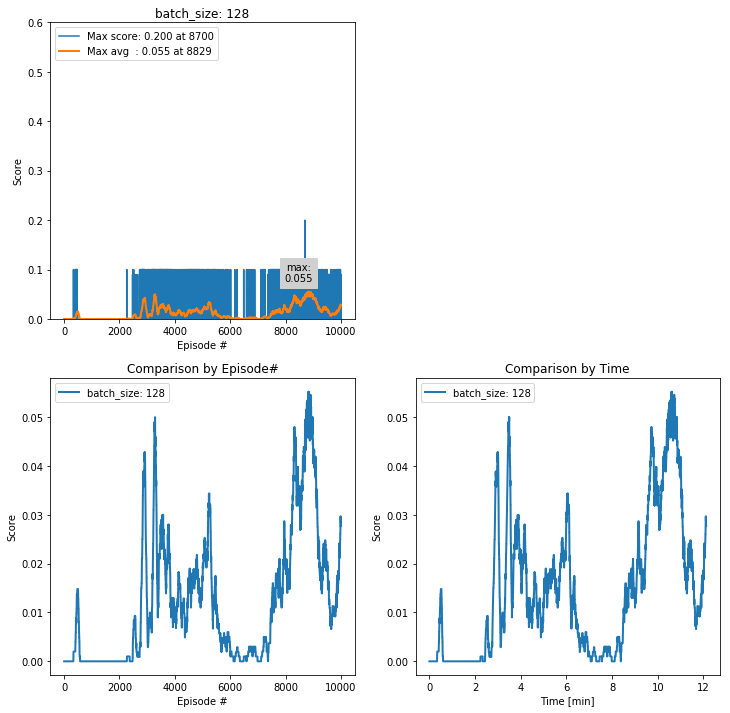

In [25]:
plot_results(['20181227182258'], measure='batch_size')

Ok, that was not very successful, but all code seems to work and it is clear that we need to do some tunning. Because we need to increase the number of episodes we need to train on, we will also change the `eps_decay` parameter so that the eps factor in the application of the noise decreases slower.

### Impact of `batch_size`

Let's run the training for a number of `batch_size` options.

In [26]:
batch_sizes = [32, 64, 128, 256]

# change this is you want to re-execute the training
reexecute2 = False

if reexecute2:
    for batch_size in batch_sizes:
        memory = ReplayBuffer(100000)
        memory.load('memory/random_memory_100000.dat')
        agent = MADDPGAgent(num_agents=num_agents, 
                            state_size=obs_size, 
                            action_size=action_size, 
                            actor_units=[256, 128], 
                            critic_units=[[256], [256, 128]], 
                            memory=memory, 
                            batch_size=batch_size, 
                            device=device, 
                            lr_actor=1e-4, 
                            lr_critic=1e-4, 
                            weight_decay=0, 
                            gamma=0.99, 
                            tau=1e-3, 
                            update_every=10)

        trainer(env=env,
                brain_name=brain_name,
                agent=agent,
                n_episodes=100000,
                t_max=10800,
                print_every=None,
                save=True,
                eps_decay=0.9999)


The results were:
```
runID: 20181227185421
Episode: 18394 Score: 2.500 Average: 0.522 Steps: 1001 Duration: 4.6s Running: 2440.8s
Environment solved in 18394 episodes!	Average Score: 0.52	 In In 2440.8s
runID: 20181227193514
Episode: 30470 Score: 1.700 Average: 0.501 Steps:  647 Duration: 3.0s Running: 3248.9s
Environment solved in 30470 episodes!	Average Score: 0.50	 In In 3248.9s
runID: 20181227202943
Episode: 17271 Score: 1.400 Average: 0.501 Steps:  526 Duration: 2.0s Running: 1989.5s
Environment solved in 17271 episodes!	Average Score: 0.50	 In In 1989.5s
runID: 20181227210311
Episode: 47697 Score: 0.000 Average: 0.044 Steps:   15 Duration: 0.1s Running: 4619.7s
```
For the last run I have stopped the execution as the model did not seem to make any progress as was already performing worse than all other runs.

Let us plot the results:

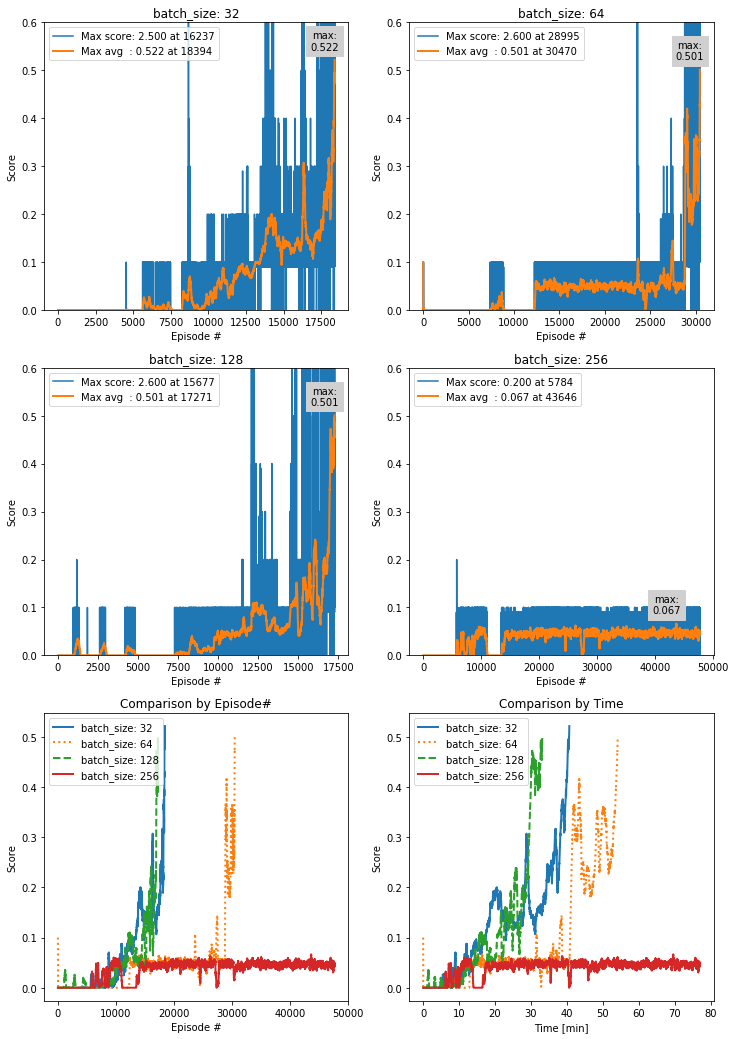

In [27]:
plot_results(['20181227185421', '20181227193514', 
              '20181227202943', '20181227210311'], 
             measure='batch_size')

The good news is that 3 of the runs have actually solved the problem. The fastest seemed to be with a `batch_size` of 128. This one solved the problem in just over 33 minutes and 17,271 episodes.

It is not clear if there is really a pattern in the behaviour as a function of `batch_size`. The lower number for this parameter seems to produce sligtly more stable training curves.

We will use the value of 32 as a benchmark and we will now try to investigate the impact of `update_every` parameter.

### Impact of `update_every`

`update_every` controls how often (after how many steps) the model will attempt to train. A smaller number will result is a larger numer of training steps for the same number of steps and episodes produced by the environment. We will evaluate the impact of this parameter with values 4, 8, 16 and 32.

In [28]:
update_everys = [4, 8, 16, 32]

# change this is you want to re-execute the training
reexecute3 = False

if reexecute3:

    for update_every in update_everys:
        memory = ReplayBuffer(100000)
        memory.load('memory/random_memory_100000.dat')
        agent = MADDPGAgent(num_agents=num_agents, 
                            state_size=obs_size, 
                            action_size=action_size, 
                            actor_units=[256, 128], 
                            critic_units=[[256], [256, 128]], 
                            memory=memory, 
                            batch_size=32, #fixed
                            device=device, 
                            lr_actor=1e-4, 
                            lr_critic=1e-4, 
                            weight_decay=0, 
                            gamma=0.99, 
                            tau=1e-3, 
                            update_every=update_every)

        trainer(env=env,
                brain_name=brain_name,
                agent=agent,
                n_episodes=50000,
                t_max=3600,
                print_every=None,
                save=True,
                eps_decay=0.9999)

The results reported were:
```
runID: 20181228140432
Episode: 6923 Score: 2.700 Average: 0.506 Steps: 1001 Duration: 5.2s Running: 1105.6s
Environment solved in 6923 episodes!	Average Score: 0.51	 In In 1105.6s
runID: 20181228142303
Episode: 24673 Score: 2.600 Average: 0.506 Steps: 1001 Duration: 4.1s Running: 2983.8s
Environment solved in 24673 episodes!	Average Score: 0.51	 In In 2983.8s
runID: 20181228151309
Episode: 50000 Score: 0.100 Average: 0.045 Steps:   46 Duration: 0.2s Running: 3488.0s
Failed to converge in 50000 episodes.	Average Score: 0.05	 In 3488.0
runID: 20181228161144
Episode: 50000 Score: 0.000 Average: 0.000 Steps:   14 Duration: 0.1s Running: 2575.9s
Failed to converge in 50000 episodes.	Average Score: 0.00	 In 2575.9
```
Let us plot the results:

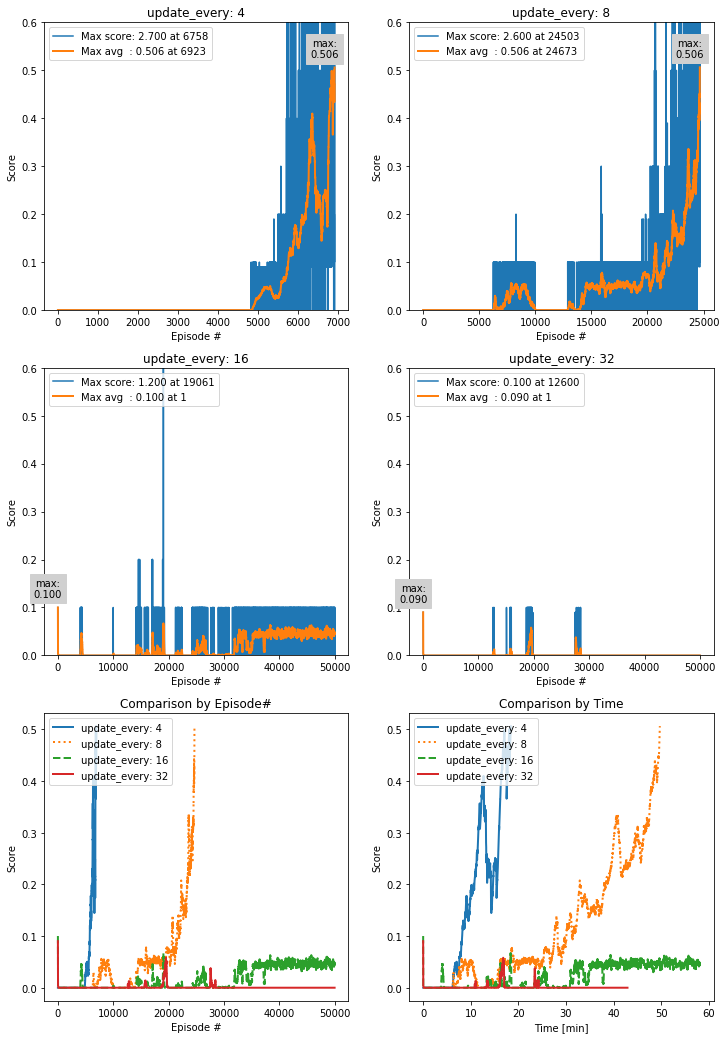

In [29]:
plot_results(['20181228140432','20181228142303', 
              '20181228151309', '20181228161144'], 
             measure='update_every')

The results are indicating that a more often update (training) of the model is beneficial: with `update_every` 4 we have the best result until now, a little over 18m and 6,920 episodes. This performance degrades when using a parameter of 8 with an increase to 2.7x in execution time and 3.5x in the number of episodes. The last two runs, for 16 and 32 failed to converge to a solution within the allocated 50,000 episodes, with the last one particularly flat at 0 all the way to the end.

Although it might have been expected that a higher `update_evry` parameter would result in a large number of episodes needed for training, the result are dramatic: it is not that the model needs double or 4 times more episodes to converge; instead it looks like the model fails to learn anything at all.

### Impact of Model: Actor Network

Let us try to determine the impact of the structure of the network on the performance of the training. We will start with the Actor NN model. In the previous runs we have used a structure with 2 hidden layer using 256 ann 128 nodes respectively. We will try to understand the impact of the numer of nodes and the number of layers on the performance of the Actors.

We will try the following combinations:

- one layer: 64 nodes
- one layer: 128 nodes
- two layers: 64, 32 nodes
- two layers: 128, 64 nodes
- three layers: 64, 32, 16 nodes
- three layers: 128, 64, 32 nodes

In [30]:
actor_unitss = [[64], 
                [128], 
                [64, 32], 
                [128, 64], 
                [64, 32, 16], 
                [128, 64, 32]]

# change this is you want to re-execute the training
reexecute4 = False

if reexecute4:

    for actor_units in actor_unitss:
        memory = ReplayBuffer(100000)
        memory.load('memory/random_memory_100000.dat')
        agent = MADDPGAgent(num_agents=num_agents, 
                            state_size=obs_size, 
                            action_size=action_size, 
                            actor_units=actor_units, 
                            critic_units=[[256], [256, 128]], 
                            memory=memory, 
                            batch_size=32,       #fixed
                            device=device, 
                            lr_actor=1e-4, 
                            lr_critic=1e-4, 
                            weight_decay=0, 
                            gamma=0.99, 
                            tau=1e-3, 
                            update_every=4)      # fixed

        trainer(env=env,
                brain_name=brain_name,
                agent=agent,
                n_episodes=50000,
                t_max=3600,
                print_every=None,
                save=True,
                eps_decay=0.9999)

The reported numbers were:
```
runID: 20181228172449
Episode: 13223 Score: 1.600 Average: 0.503 Steps:  601 Duration: 3.1s Running: 1441.0s
Environment solved in 13223 episodes!	Average Score: 0.50	 In In 1441.0s
runID: 20181228174858
Episode: 6984 Score: 2.390 Average: 0.508 Steps:  899 Duration: 4.3s Running: 1002.8s
Environment solved in 6984 episodes!	Average Score: 0.51	 In In 1002.8s
runID: 20181228180554
Episode: 6934 Score: 2.600 Average: 0.524 Steps: 1001 Duration: 5.2s Running: 1089.2s
Environment solved in 6934 episodes!	Average Score: 0.52	 In In 1089.2s
runID: 20181228182409
Episode: 34634 Score: 0.000 Average: 0.051 Steps:   14 Duration: 0.1s Running: 3600.1s
Failed to converge in 50000 episodes.	Average Score: 0.05	 In 3600.1
runID: 20181228192447
Episode: 7709 Score: 2.700 Average: 0.509 Steps: 1001 Duration: 5.3s Running: 1163.3s
Environment solved in 7709 episodes!	Average Score: 0.51	 In In 1163.3s
runID: 20181228194415
Episode: 17360 Score: 2.500 Average: 0.506 Steps:  948 Duration: 5.4s Running: 2511.9s
Environment solved in 17360 episodes!	Average Score: 0.51	 In In 2511.9s
```
Let us plot the results:

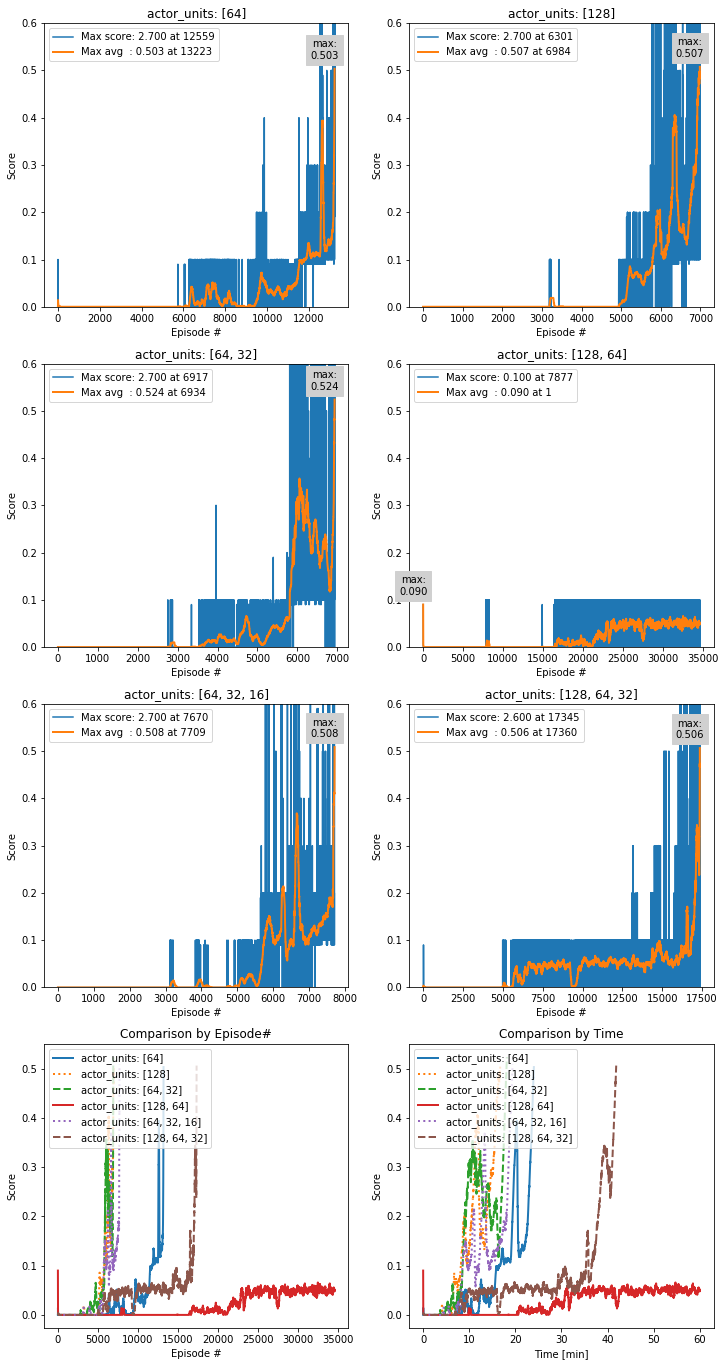

In [31]:
plot_results(['20181228172449', '20181228174858', 
              '20181228180554', '20181228182409', 
              '20181228192447', '20181228194415'], 
              measure='actor_units')

This makes for some interesting results: it seems that (at least for the performance we are looking for 0.5) smaller is better. The actor networks with one single layer and smaller number of units seem to train faster. The networks with larger number of units or multiple layers take longer to train and seem to be vulnerable to the "0.05 syndrome" (that we already saw a couple of times earlier and will dicuss later).

In a way this is expected: the input for an Actor is a 24-size vector (the observations) and the output is a 2-size vector. Using a smaller network seems to be more appropriate.

### Impact of Model: Critic Network

Let us see what is the impact on the Critic network. Since this network needs to process a lot more data (the observation space is doubled and we add on top the action space), we would expect a more sizeable network to be needed. But how much more bigger? We will try the following combinations:

- observation layer: [64], value layer: [64]
- observation layer: [128], value layer: [128]
- observation layer: [64], value layer: [64, 32]
- observation layer: [128], value layer: [128, 64]
- observation layer: [64], value layer: [64, 32, 16]
- observation layer: [128], value layer: [128, 64, 32]

In [32]:
critic_unitss = [[[64], [64]],
                 [[128], [128]],
                 [[64], [64, 32]], 
                 [[128], [128, 64]], 
                 [[64], [64, 32, 16]], 
                 [[128], [128, 64, 32]]]

# change this is you want to re-execute the training
reexecute5 = False

if reexecute5:

    for critic_units in critic_unitss:
        memory = ReplayBuffer(100000)
        memory.load('memory/random_memory_100000.dat')
        agent = MADDPGAgent(num_agents=num_agents, 
                            state_size=obs_size, 
                            action_size=action_size, 
                            actor_units=[128],   # fixed 
                            critic_units=critic_units, 
                            memory=memory, 
                            batch_size=32,       #fixed
                            device=device, 
                            lr_actor=1e-4, 
                            lr_critic=1e-4, 
                            weight_decay=0, 
                            gamma=0.99, 
                            tau=1e-3, 
                            update_every=4)      # fixed

        trainer(env=env,
                brain_name=brain_name,
                agent=agent,
                n_episodes=50000,
                t_max=3600,
                print_every=None,
                save=True,
                eps_decay=0.9999)

The results were:
```
runID: 20181228213216
Episode: 15033 Score: 0.400 Average: 0.503 Steps:  181 Duration: 0.8s Running: 2160.2s
Environment solved in 15033 episodes!	Average Score: 0.50	 In In 2160.2s
runID: 20181228220826
Episode: 33398 Score: 0.100 Average: 0.042 Steps:   48 Duration: 0.2s Running: 3600.0s
Failed to converge in 50000 episodes.	Average Score: 0.04	 In 3600.0
runID: 20181228230907
Episode: 35207 Score: 0.090 Average: 0.050 Steps:   33 Duration: 0.2s Running: 3600.1s
Failed to converge in 50000 episodes.	Average Score: 0.05	 In 3600.1
runID: 20181229000956
Episode: 8703 Score: 1.500 Average: 0.514 Steps:  508 Duration: 2.5s Running: 1003.8s
Environment solved in 8703 episodes!	Average Score: 0.51	 In In 1003.8s
runID: 20181229002652
Episode: 14090 Score: 0.300 Average: 0.501 Steps:  105 Duration: 0.5s Running: 1934.6s
Environment solved in 14090 episodes!	Average Score: 0.50	 In In 1934.6s
runID: 20181229005924
Episode: 8689 Score: 2.600 Average: 0.506 Steps: 1001 Duration: 5.0s Running: 1314.2s
Environment solved in 8689 episodes!	Average Score: 0.51	 In In 1314.2s
```
Let's plot the results:

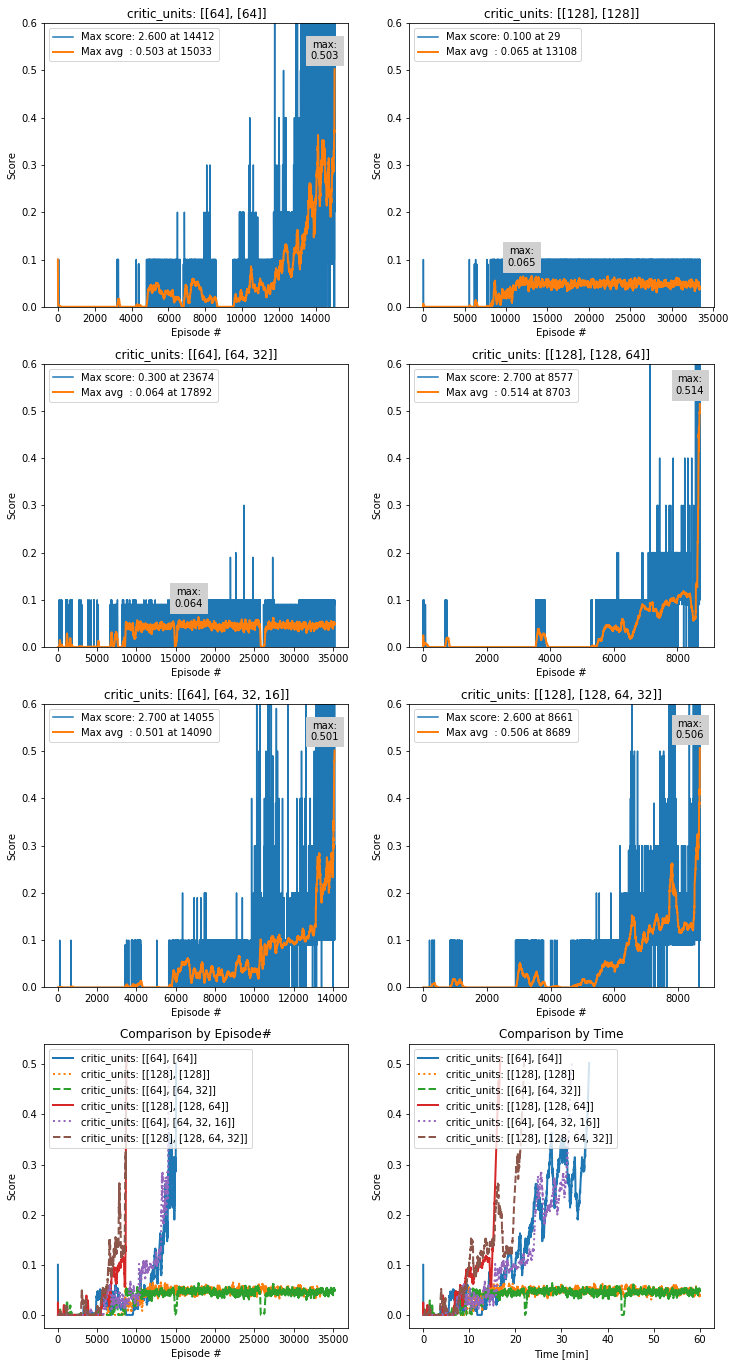

In [33]:
plot_results(['20181228213216', '20181228220826', 
              '20181228230907', '20181229000956', 
              '20181229002652', '20181229005924'], 
             measure='critic_units')

We see here an reversal of impact: the more complex networks for the Critic seem to perform better. The structure [128], [128, 64] was the fastest and solved the problem in 16m42s and 8,703 episodes, followed closely by the [128], [128, 64, 32] that solved the problem in almost 22m and 8,689 episodes.

Two of the smaller structures have put the model in the "0.05 syndrome" and failed to converge within one hour.

## Conclusions

We have managed to solve the environment a significant number of times and we produced a number of empyrical rules related to the best tunning of the hyper-parameters for the model.

**The best result in terms of training time was 16m42s over 6,984 episodes** for the following parameters:


| parameter           | value             |
| :------------------ | :---------------- |
|<img width=200/>     |<img width=200/>   |
| actor network       | [128]             |
| critic network      | [256], [256. 128] |
| `upddate_every`     | 4                 |
| `batch_size`        | 32                |

The rest of the parameters were the same across all runs:

| parameter           | value             |
| :------------------ | :---------------- |
|<img width=200/>     |<img width=200/>   |
| buffer memory size  | 100,000           |
| lr_actor            | 1e-4              |
| lr_critic           | 1e-4              |
| weight_decay        | 0                 |
| gamma               | 0.99              |
| tau                 | 1e-3              |
| eps_decay           | 0.9999            |
| eps_min             | 0.05              |

**The best result in terms of number of episodes was 6,923 and 18m24s** for the following parameters:

| parameter           | value             |
| :------------------ | :---------------- |
|<img width=200/>     |<img width=200/>   |
| actor network       | [256, 128]        |
| critic network      | [256], [256. 128] |
| `upddate_every`     | 4                 |
| `batch_size`        | 32                |

There are a number of conclusions that we can draw based on the very limited number of training runs executed:

1. The **variability of the training is very high** and is subject to a lot of randomness. In a situation where time and hardware would allow this, we should have run the training for the same parameteres multiple times and use an average of the results as a more objective performance of a given set.


2. The performance of the training is determined by **both** agents' ability to learn. If one agent learns relatively quickly and the other one remains "dumb" and "drops the ball" (literarly) we will obtain a very low average score of around 0.05 (the **0.05 syndrome**) corresponding to the fact that one agent manages to hit the ball more or less every time (thus recording a +0.1 reward) while the other misses it. For that episode the score will be given by the highest score between the agents, which will be +0.1 in this case. The next episode the ball will start with the other agent that will miss it directly, thus scoring 0.0, which will also be the score for the episode. Thus the sequence of scores will be 0.1, 0.0, 0.1, etc. making an average of around 0.05. We have seen this phenomenon happening several times in the training and later in this document we will try to suggest a few possible way to overcome this issue.


3. **Actor networks perform better is they are smaller and with one hidden layer only**. Given the relatively uncomplicated and correlated information in the observation space more complex networks will ry to overfit and learn bad habbits that are slow to correct later. Larger networks will also make the training slower.


4. **Critic network performs better if it is more complex**. Due to the higher complexity of the data that this network needs to process, a more complex network with more layers and nodes seems to help.


5. You need to be prepared to run the traning over a **large number of episodes**. In general the first 5,000 - 10,000 episodes the model will score very close to 0.0 and will not seem to learn anything. For this reason you also need to make sure that the **`eps_decay` is very close to 1.0** so that it will still allow exploration when running training after 10,000 episodes.


6. **Smaller batch sizes** (`batch_size = 32`) and **more often learning** (`update_every = 4`) seem to provide better performance and faster learning.

## Future Work

The challenge required for this exercise was to have a running average of over 0.5 over 100 episodes. This did not seem to be extremely challenging and we managed to obtain that score in the majority of the training runs. But it is visible in the results that the maximum score that can be obtained in an episode is 2.7 which suggests that we could challenge ourselves for a much higher average score than 0.5, representing a more "expert" player. There are a couple of strategies that we could use to improve this performance:

- fine tune the parameters and increase the training time to reach a higher average. This might prove to be very tricky given the variability of the training process and the dependency on the both of the actors to train well.


- a better solution would be to separate the saving of the weights for the actors and the critic and **run the training with multiple baches of actors and the same critic** (with the critic starting from the previous run), then select the best actors and match them to play against each other, until we end up with only one single actor that will perform best. This is similar to a real tennis tournament and has the advantage that it will face agents of higher skill and provide the opportunity to improve. Matching a high skill actor with a very dumb one will in general be a waste of time and both actors will miss the opportunity to improve.


$$\pagebreak$$

## Appendix - Code Listing

### `buffer.py`

This file contains the implementation of the replay buffer memory.

In [34]:
!pygmentize buffer.py

from collections import deque, namedtuple
import random
import pickle
import torch
import numpy as np


Experience = namedtuple("Experience", 
                        field_names=["obs", 
                                     "actions", 
                                     "rewards", 
                                     "next_obs", 
                                     "dones"])

# pylint: disable=E1101


    def __init__(self,size):
        self.size = size
        self.memory = deque(maxlen=self.size)


    def push(self,obs, actions, rewards, next_obs, dones):
        """push into the buffer"""
        e = Experience(obs, actions, rewards, next_obs, dones)
        self.memory.append(e)


    def sample(self, batchsize, device='cpu'):
        """sample from the buffer"""
        samples = random.sample(self.memory, batchsize)

        # get each item from Experience as a tensor
        obs = torch.from_numpy(np.stack([e.obs for e in samples \
                            if e is not 

### `OUNoise.py`

This file contains the implementation of the Ornstein–Uhlenbeck noise generator. It is unchanged from the version referenced below.

In [35]:
!pygmentize OUNoise.py

import numpy as np
import torch


# from https://github.com/songrotek/DDPG/blob/master/ou_noise.py
class OUNoise:

    def __init__(self, action_dimension, scale=0.1, mu=0, theta=0.15, sigma=0.2):
        self.action_dimension = action_dimension
        self.scale = scale
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu
        self.reset()


    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu


    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state * self.scale


    def __call__(self):
        return self.noise()


### `network.py`

This file includes the classes used to model the Actor and Crtitic Neural Networks.

In [36]:
!pygmentize network.py

import torch
import torch.nn as nn
import numpy as np

# pylint: disable=E1101

def hidden_init(layer):
    """Calculates the initialization parameters for the hidden layers
    """
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model.
    
    Based on the code from ddpg-pendulum.
    """

    def __init__(self, in_size, fc_units, out_size):
        """Initialize parameters and build model.
        Params
            in_size (int): Dimension of input tensor
            fc_units (list int): Number of nodes in the hidden layers
            out_size (int): Dimension of output tensor

        """
        super(Actor, self).__init__()
        units = [in_size] + fc_units + [out_size]
        layers = []
        for i in range(len(units)-2):
            layer = nn.Linear(units[i], units[i+1])
            layer.weight.data.uniform_(*hidden_init(layer))
            layers.append(layer)
            

### `agent.py`

This file contains the implementation of the agent.

In [37]:
!pygmentize agent.py

import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F

from network import MADDPGNet
from OUNoise import OUNoise

# pylint: disable=E1101

class MADDPGAgent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, num_agents,
                 state_size, action_size,
                 actor_units, critic_units,
                 memory,
                 batch_size,
                 device='cpu',
                 lr_actor=1e-4, lr_critic=1e-4,
                 weight_decay=0,
                 gamma=0.99,
                 tau=1e-3,
                 update_every = 10):
        """Initialize an Agent object.
        
        Params
            num_agents (int): number of agents
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            actor_units (list int): configuration of layers for Actor nets
            critic_units (list list int): configuration of layer

### trainer.py

This file contains the implementation of the training function.

In [38]:
!pygmentize trainer.py

import time
import json
import numpy as np
from collections import deque


def trainer(env, brain_name,
            agent, 
            n_episodes=1000, t_max=10800,
            print_every=None,
            save=True,
            eps_start=1.0, eps_min=0.05, eps_decay=0.99,
            threshold=0.5):
    """A help function that will handle the interaction with the environment
    and manage the agent.
    
    Params:
    env (Unity environment): the environment to work with
    brain_name (string): the name of the brain in the environment
    agent (and Agent class): the agent that will be trained; the Agent
            must implement the methods `act`, `step` and `save`
    n_episodes (int): maximum number of episodes the trainer will run
    t_max (int): maximum duration to run the training is seconds
    save (Bool): saves the model with the best score
    eps_start, eps_min (float): parameters for noise
    eps_decay (float): dacay factor for applying noise
    threshold (float)